In [2]:
"""
SO! I am creating a market trend prediction system. I will use Apple stocks if I can obtain them. 
Basic Idea:
Get the data, pick a model, train it, fine tune it, apply it to historical predications,apply it to current market data
"""
# Get data apple data from yfinance 
import pandas as pd
import yfinance as yf
# Fetching data
# Stock symbol
sym = 'AAPL'
# Downloading the data from the module
aapl_rdata = yf.download(sym, start='2020-01-01', end='2023-01-01')

# Getting the stock object from the module. This allows us, via stock object class, to know access features and perform actions related to the stock 
stock = yf.Ticker(sym)

# e.g Checking stock infomation, accessing metadata, printing metadata
info = stock.info

company_name = info['longName']
sector = info['sector']
industry = info['industry']

# Print specific metadata
print(f"Company Name: {company_name}")
print(f"Sector: {sector}")
print(f"Industry: {industry}")

# Data cleaning and preprocessing
aapl_cdata = aapl_rdata['Close'].dropna() # Select Closing data and drop NAN entries

/home/wbboinde19/.local/lib/python3.8/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
[*********************100%%**********************]  1 of 1 completed

Company Name: Apple Inc.
Sector: Technology
Industry: Consumer Electronics


In [3]:
# Calculate technical indicators/ Feature extraction
import talib
# moving average
aapl_rdata['SMA_50'] = aapl_rdata['Close'].rolling(window=50).mean()

# This is the Relative Strength Index. 
aapl_rdata['RSI'] = talib.RSI(aapl_rdata['Close'], timeperiod=14) 
# It is a measures the speed and change of price movements 

# MACD - Moving Average Convergence Divergence
# Calculate 12-day Exponential Moving Average(EMA)
aapl_rdata['EMA_12'] = aapl_rdata['Close'].ewm(span=12, adjust=False).mean()
# Calculate 26-day EMA
aapl_rdata['EMA_26'] = aapl_rdata['Close'].ewm(span=26, adjust=False).mean()
# Calculate MACD line
aapl_rdata['MACD'] = aapl_rdata['EMA_12'] - aapl_rdata['EMA_26']

# Calculate 9-day EMA of MACD as the signal line
aapl_rdata['Signal_Line'] = aapl_rdata['MACD'].ewm(span=9, adjust=False).mean()


# Target Variable Definition - Trend
# Create a binary target variable
aapl_rdata['UpwardTrend'] = (aapl_rdata['Close'].shift(-1) > aapl_rdata['Close']).astype(int) # 1 if up, 0 if down


In [4]:
aapl_rdata,

(                  Open        High         Low       Close   Adj Close  \
 Date                                                                     
 2020-01-02   74.059998   75.150002   73.797501   75.087502   73.059418   
 2020-01-03   74.287498   75.144997   74.125000   74.357498   72.349113   
 2020-01-06   73.447502   74.989998   73.187500   74.949997   72.925644   
 2020-01-07   74.959999   75.224998   74.370003   74.597504   72.582664   
 2020-01-08   74.290001   76.110001   74.290001   75.797501   73.750237   
 ...                ...         ...         ...         ...         ...   
 2022-12-23  130.919998  132.419998  129.639999  131.860001  130.959946   
 2022-12-27  131.380005  131.410004  128.720001  130.029999  129.142441   
 2022-12-28  129.669998  131.029999  125.870003  126.040001  125.179672   
 2022-12-29  127.989998  130.479996  127.730003  129.610001  128.725311   
 2022-12-30  128.410004  129.949997  127.430000  129.929993  129.043121   
 
                Volume 

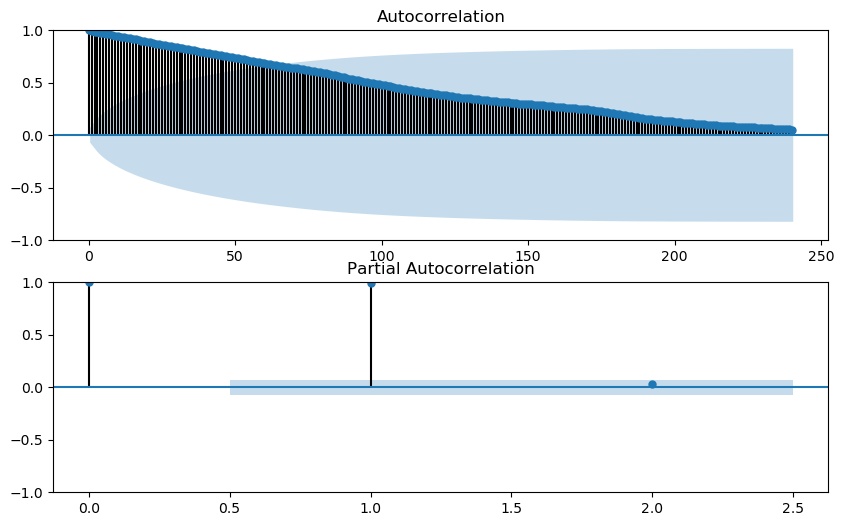

/home/wbboinde19/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/wbboinde19/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/wbboinde19/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/wbboinde19/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible st

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  756
Model:               ARIMA(40, 1, 90)   Log Likelihood               -1762.496
Date:                Thu, 07 Mar 2024   AIC                           3786.992
Time:                        00:08:54   BIC                           4393.092
Sample:                             0   HQIC                          4020.463
                                - 756                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0411      8.124      0.005      0.996     -15.881      15.963
ar.L2         -0.1394      7.650     -0.018      0.985     -15.133      14.854
ar.L3         -0.0583      6.005     -0.010      0.9

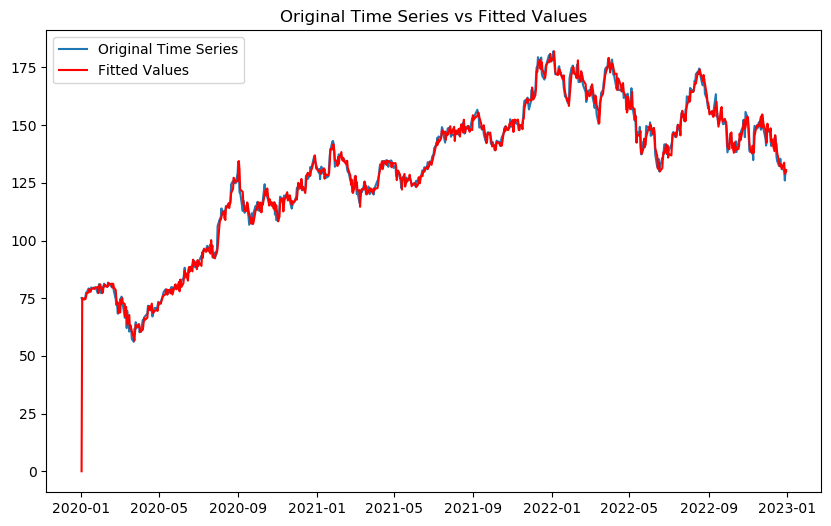

In [12]:
# Model Selection - ARIMA
"""
statsmodels - 
ARIMA: 
"""
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

# Assuming you have a time series 'ts' with datetime index
# First, let's visualize the autocorrelation and partial autocorrelation plots.
"""
Visualizing the autocorrelation and partial autocorrelation plots is an important 
step in the process of selecting the appropriate parameters (p, d, q) for an ARIMA model
"""
fig, ax = plt.subplots(2, figsize=(10, 6))
plot_acf(aapl_cdata, ax=ax[0], lags=240)
plot_pacf(aapl_cdata, ax=ax[1], lags=2)
plt.show()

# Fit the ARIMA model
# Specify the order parameter (p, d, q)
order = (40, 1, 90)  # Replace p, d, q with appropriate values

# Create and fit the ARIMA model
arima_model = ARIMA(aapl_cdata, order=order)
arima_results = arima_model.fit()

# Print summary of the model
print(arima_results.summary())
with open('Arima_results.txt', "a") as file:
    file.write(f'{arima_results.summary()}')
# Plot the original time series and fitted values
plt.figure(figsize=(10, 6))
plt.plot(aapl_cdata, label='Original Time Series')
plt.plot(arima_results.fittedvalues, color='red', label='Fitted Values')
plt.legend()
plt.title('Original Time Series vs Fitted Values')
plt.show()



/home/wbboinde19/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/wbboinde19/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/wbboinde19/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/wbboinde19/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-s

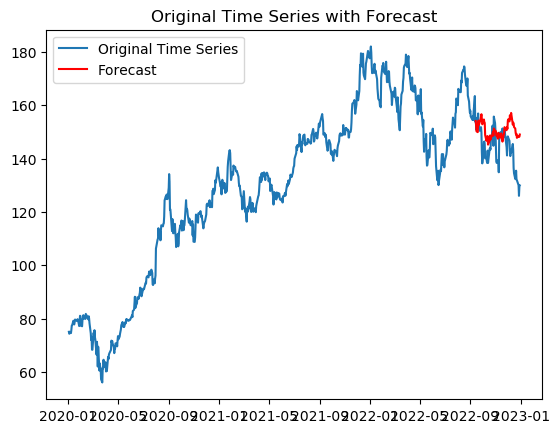

In [14]:
# Split data into training and testing
tend = int(0.9 * len(aapl_rdata)) 
training = aapl_rdata[:tend]
testing = aapl_rdata[tend:]

# Training the model
model = ARIMA(training['Close'], order=order)
results = model.fit()

# Make predictions
forecast = results.get_forecast(steps=len(testing))
# Get the forecasted values and associated confidence intervals
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plot the forecasted values
# plt.figure(figsize=(10, 6))
plt.plot(aapl_cdata.index, aapl_cdata, label='Original Time Series')
plt.plot(testing.index, forecast_values, color='red', label='Forecast')
plt.legend()
plt.title('Original Time Series with Forecast')
plt.show()